In [1]:
%config IPCompleter.greedy = True
%config Completer.use_jedi = False

In [5]:
import numpy as np # linear algebra
from numpy.lib.stride_tricks import sliding_window_view
import cupy as cp
import tensorflow as tf
import tensorflow_probability as tfp
import timeseriesanalysis as tsa
!pip install bezier
!pip install lmoments3
import lmoments3 as lm
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit
import itertools 
from scipy.special import comb
from scipy import signal
from scipy.special import comb
import torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 2.5 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 90.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.3 which is incompatible.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.0 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.2.3 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.3 which is incompatible.
langc

# **Kernel Function Computations For GPUs**

In [2]:
def remove_duplicate_arrays(array_list):
    """
    Removes duplicate NumPy arrays from a list, returning a new list
    containing only unique arrays.

    Args:
        array_list (list of numpy arrays): A list containing NumPy arrays.

    Returns:
        list of numpy arrays: A new list containing only the unique NumPy arrays
                              from the input list. The order of arrays in the
                              returned list is preserved from the original list
                              as much as possible (the *first* occurrence of each
                              unique array is kept).
    """

    unique_arrays = []
    seen = set()  # Use a set to track seen array's byte representations

    for arr in array_list:
        # Convert the array to bytes for efficient set comparison
        arr_bytes = arr.tobytes()

        if arr_bytes not in seen:
            unique_arrays.append(arr)
            seen.add(arr_bytes)

    return unique_arrays
    

def bezier_curve_fast_cupy(control_points, num_points=100):
    """
    Generates 2D Bézier curves for a batch of control point arrangements,
    optimized for speed using CuPy, and scales each curve so that its points sum to 1.

    Args:
        control_points (cupy array): A CuPy array of shape (num_arrangements, n+1, 2)
            representing the control points for each Bézier curve.
        num_points (int): The number of points to generate along each curve.

    Returns:
        cupy array: A CuPy array of shape (num_arrangements, num_points, 2) containing the (x, y)
            coordinates of the points on the Bézier curves, scaled to sum to 1.
    """

    n = control_points.shape[1] - 1
    num_arrangements = control_points.shape[0]

    # Precompute Bernstein basis polynomials for all t values
    t = cp.linspace(0, 1, num_points)[:, None]

    # Precompute the binomial coefficients (on the CPU, then transfer)
    binomial_coefficients = np.array([comb(n, i) for i in range(n + 1)])
    binomial_coefficients_gpu = cp.asarray(binomial_coefficients)

    # Vectorized calculation of Bernstein polynomials
    bernstein_polynomials = binomial_coefficients_gpu * (t ** cp.arange(n + 1).reshape(1, -1)) * ((1 - t) ** cp.arange(n, -1, -1).reshape(1, -1))

    # Calculate curve points using vectorized operations (Batch Matrix Multiplication)
    points = cp.matmul(bernstein_polynomials, control_points)

    # Scale the curve to sum to 1
    curve_sum = cp.sum(points, axis=1, keepdims=True)
    mask = (curve_sum != 0)
    points = cp.where(mask, points / curve_sum, points)

    return points.astype(cp.float16)



def generate_coordinate_arrangements_cupy(point_ranges):
    """
    Generates all possible coordinate arrangements for a specified number of points,
    where each point can have its own independent x and y ranges.

    Args:
        point_ranges (list of tuples): A list of tuples, where each tuple represents the
            (x_range, y_range) for a single point.  Each x_range and y_range are themselves
            tuples specifying (min_x, max_x) and (min_y, max_y), respectively.

            For example:
            `point_ranges = [((0, 2), (0, 3)), ((1, 4), (2, 5)), ((0, 1), (1, 1))]`
            means:
                - Point 1: x can be 0, 1, or 2; y can be 0, 1, 2, or 3.
                - Point 2: x can be 1, 2, 3, or 4; y can be 2, 3, 4, or 5.
                - Point 3: x can be 0 or 1; y can only be 1.

    Returns:
        A CuPy array of shape (num_arrangements, num_points, 2).
    """
    arrangements = []
    num_points = len(point_ranges)

    def generate_recursive(current_arrangement, point_index):
        if point_index == num_points:
            arrangements.append(np.array(current_arrangement))
            return

        x_range, y_range = point_ranges[point_index]
        for x in range(x_range[0], x_range[1] + 1):
            for y in range(y_range[0], y_range[1] + 1):
                new_arrangement = current_arrangement + [[x, y]]
                generate_recursive(new_arrangement, point_index + 1)

    generate_recursive([], 0)
    return cp.asarray(arrangements)


# Example Usage:
# Define the individual x and y ranges for each point

min_x = 0
max_x = 4
min_y = 0
max_y = 7

point_ranges = [
    ((min_x, min_x), (min_y, max_y)),
    ((min_x, max_x), (min_y, max_y)),
    ((min_x, max_x), (min_y, max_y)),
    ((max_x, max_x), (min_y, max_y))  
]

# Generate all arrangements
all_arrangements_gpu = generate_coordinate_arrangements_cupy(point_ranges)

min_window_size = 10
max_window_size = 1000
window_size_step = 15
loop_points = range(min_window_size, max_window_size, window_size_step)
enum_loop_points = enumerate(loop_points)

# Preallocate the array to store the kernel functions (on the CPU)
kernel_functions = [] # Changed from np.empty to a list

with tqdm(desc="Processing") as pbar:
    for window_index, window_size in enum_loop_points:
        # Calculate all Bezier curves for the current window size in one go!
        all_curves = bezier_curve_fast_cupy(all_arrangements_gpu, num_points=window_size) #shape is num_arrangements, num_points, 2
        y_coords_gpu = all_curves[:, :, 1]  # Extract y-coordinates; shape is num_arrangements, num_points

        # Copy y-coordinates to CPU as a NumPy array
        y_coords_cpu = cp.asnumpy(y_coords_gpu)  #Shape is now num_arrangements, num_points

        #Store NumPy Array as a 2D array in the list.
        kernel_functions.append(y_coords_cpu) #Changed to append, not assign

        pbar.update(1)

# leave unique kernel functions only
for i in range(len(kernel_functions)):
    kernel_functions[i] = remove_duplicate_arrays(kernel_functions[i])

Processing: 66it [00:11,  5.72it/s]


# **Kernel Function Computations For TPUs**

In [ ]:
tfd = tfp.distributions

def bezier_curve_fast_tf(control_points, num_points=100):
    """
    Generates 2D Bézier curves for a batch of control point arrangements,
    optimized for speed using TensorFlow and TPUs, and scales each curve so that its points sum to 1.

    Args:
        control_points (tf.Tensor): A TensorFlow tensor of shape (num_arrangements, n+1, 2)
            representing the control points for each Bézier curve.
        num_points (int): The number of points to generate along each curve.

    Returns:
        tf.Tensor: A TensorFlow tensor of shape (num_arrangements, num_points, 2) containing the (x, y)
            coordinates of the points on the Bézier curves, scaled to sum to 1.
    """

    n = tf.cast(tf.shape(control_points)[1] - 1, dtype=tf.float32)  # Use tf.cast
    num_arrangements = tf.shape(control_points)[0]

    # Precompute Bernstein basis polynomials for all t values
    t = tf.linspace(0.0, 1.0, num_points)[:, None]

    # Precompute the binomial coefficients (on the CPU, then transfer if needed - usually XLA handles this fine)
    binomial_coefficients = np.array([comb(int(n), i) for i in range(int(n) + 1)])
    binomial_coefficients_tf = tf.constant(binomial_coefficients, dtype=tf.float32) # Convert to tf.constant

    # Vectorized calculation of Bernstein polynomials
    arange_n_plus_1 = tf.range(int(n + 1), dtype=tf.float32)
    bernstein_polynomials = binomial_coefficients_tf * (t ** arange_n_plus_1) * ((1 - t) ** tf.reverse(arange_n_plus_1, axis=[0]))

    # Calculate curve points using vectorized operations (Batch Matrix Multiplication)
    bernstein_polynomials = tf.cast(bernstein_polynomials, dtype=tf.float32)
    control_points = tf.cast(control_points, dtype=tf.float32)
    points = tf.matmul(bernstein_polynomials, control_points)

    # Scale the curve to sum to 1
    curve_sum = tf.reduce_sum(points, axis=1, keepdims=True)
    mask = tf.not_equal(curve_sum, 0)
    points = tf.where(mask, points / curve_sum, points)

    return tf.cast(points, dtype=tf.float16)


def generate_coordinate_arrangements_tf():
    """
    Generates all possible coordinate arrangements for four points, as a TensorFlow tensor.

    Returns:
        A TensorFlow tensor of shape (num_arrangements, 4, 2).
    """
    arrangements = []
    for y1 in range(0, 7):
        for x2 in range(0, 5):
            for y2 in range(0, 7):
                for x3 in range(0, 5):
                    for y3 in range(0, 7):
                        for y4 in range(0, 7):
                            point1 = [0, y1]
                            point2 = [x2, y2]
                            point3 = [x3, y3]
                            point4 = [4, y4]
                            arrangements.append(np.array([point1, point2, point3, point4]))

    return tf.constant(np.array(arrangements), dtype=tf.float32)


# TPU Strategy Setup (REQUIRED if running on TPU)
# This part needs to be adjusted based on your specific TPU setup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default strategy in case of no TPU

print("REPLICAS: ", strategy.num_replicas_in_sync)

# Now, wrap everything that uses the TPU inside the strategy scope
with strategy.scope():
    # Generate all arrangements
    all_arrangements_tf = generate_coordinate_arrangements_tf()

    min_window_size = 10
    max_window_size = 1000
    window_size_step = 15
    loop_points = range(min_window_size, max_window_size, window_size_step)
    enum_loop_points = enumerate(loop_points)

    # Preallocate the array to store the kernel functions (on the CPU)
    kernel_functions = np.empty((len(loop_points), len(all_arrangements_tf)), dtype=object)


    with tqdm(desc="Processing") as pbar:
        for window_index, window_size in enum_loop_points:
            # Calculate all Bezier curves for the current window size in one go!
            all_curves = bezier_curve_fast_tf(all_arrangements_tf, num_points=window_size) #shape is num_arrangements, num_points, 2
            y_coords_tf = all_curves[:, :, 1]  # Extract y-coordinates; shape is num_arrangements, num_points

            # Convert y_coords_tf to NumPy array
            y_coords_np = y_coords_tf.numpy()

            # Store NumPy Array in 2d output.
            kernel_functions[window_index, :] = [y_coords_np[i, :] for i in range(y_coords_np.shape[0])]

            pbar.update(1)

print("Finished processing.")

# Computations for Multiscale LTI Filter Information

In [4]:
def conv_subtract_scale(time_series, kernel_functions):
    """
    Performs convolution, subtraction, and scaling operations efficiently, 
    minimizing data conversions.

    Args:
        time_series: A 1D NumPy array of time series data.
        kernel_functions: A 2D NumPy array of kernel functions.

    Returns:
        A TensorFlow tensor representing the result of the operations.
    """

    # 1. Preprocessing & Reshaping in NumPy (Optimize for TF Input)
    time_series = np.expand_dims(time_series, axis=(0, -1))  # (1, time_series_length, 1)
    kernel_functions = np.expand_dims(kernel_functions, axis=1)  # (num_kernel_functions, 1, kernel_length)
    kernel_functions = np.transpose(kernel_functions, (2, 1, 0))  # (kernel_length, 1, num_kernel_functions)

    # 2. Convert to TensorFlow tensors
    time_series_tf = tf.convert_to_tensor(time_series, dtype=tf.float16)
    kernel_functions_tf = tf.convert_to_tensor(kernel_functions, dtype=tf.float16)

    # 3. Convolution in TensorFlow
    convolved_tf = tf.nn.convolution(
        input=time_series_tf,
        filters=kernel_functions_tf,
        padding='VALID',
        strides=1,
    )
    convolved_tf = tf.squeeze(convolved_tf, axis=0)  # Remove batch dim

    # 4. Reshape time_series_tf for subtraction (all in TensorFlow)
    time_series_tf = tf.reshape(time_series_tf, [time_series_tf.shape[1]])  #Now remove the dims for the tf tensor
    starting_index = int(time_series_tf.shape[0] - convolved_tf.shape[0])
    time_series_sliced_tf = time_series_tf[starting_index:] #Slice now in TF

    # 5. Reshape for subtraction (all in TensorFlow)
    # Determine if convolved_tf needs to be reshaped based on time_series_sliced_tf's shape
    if time_series_sliced_tf.shape[0] == convolved_tf.shape[1]:
        time_series_reshaped_tf = tf.reshape(time_series_sliced_tf, [1, -1])
    elif time_series_sliced_tf.shape[0] == convolved_tf.shape[0]:
        time_series_reshaped_tf = tf.reshape(time_series_sliced_tf, [-1, 1])
    else:
        raise ValueError("Arrays are not compatible. time_series must match either the number of rows or columns of filter outputs.")
    
    # 6. Perform subtraction *directly in TensorFlow* (No CuPy conversion anymore!)
    intermediate_result = time_series_reshaped_tf - convolved_tf
    scaled_result = intermediate_result.numpy()
    with tqdm(desc="Processing") as pbar:
        for i in range(scaled_result.shape[1]):
            scaled_result[:,i] /= np.std(scaled_result[:,i])
            pbar.update(1)
            
    return scaled_result

# Example Time Series
length = 5000
sample_rate = 10
time_series = tsa.symmetric_random_walk(length, sample_rate)
resid = conv_subtract_scale(time_series, kernel_functions[0])

Processing: 0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
Processing: 3746it [00:00, 4036.02it/s]


# Computing Sliding L-Moments

GPU Result Shape: (991, 6)
lmoments3 Result Shape: (991, 6)
Results match within tolerance: False

First 5 windows (GPU):
[[ 0.5201367   0.1876431  -0.01396361 -0.00709565  0.03010086 -0.00545312]
 [ 0.48474115  0.20629369 -0.01005074 -0.02274042  0.03467809  0.01551359]
 [ 0.48666072  0.20821324 -0.00813119 -0.02082086  0.03659765  0.01743315]
 [ 0.4967056   0.21379372 -0.00980534 -0.02919159  0.02711082  0.0191073 ]
 [ 0.45807365  0.21808615  0.0159493  -0.04022928 -0.01152111  0.05773924]]
First 5 windows (lmoments3):
[[ 0.52013673  0.18764308 -0.07441574 -0.03781461  0.16041552 -0.02906111]
 [ 0.48474117  0.20629368 -0.04872051 -0.1102332   0.16810062  0.07520148]
 [ 0.48666073  0.20821323 -0.03905216 -0.09999776  0.17577005  0.08372737]
 [ 0.4967056   0.21379372 -0.04586347 -0.13654089  0.12680834  0.08937256]
 [ 0.45807366  0.21808616  0.07313304 -0.18446508 -0.05282826  0.26475422]]
Maximum absolute difference: 0.5333197963745379


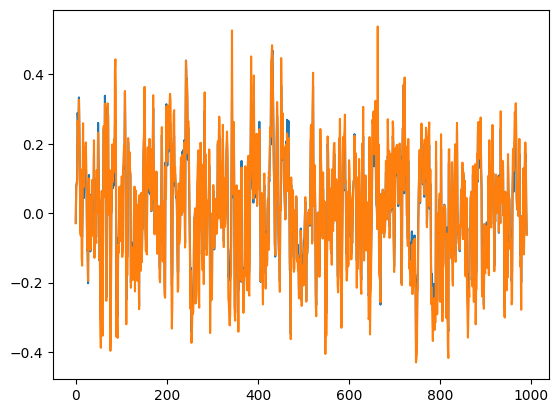

In [71]:
# Corrected L-moment weights function
def compute_lmoment_weights(W, R):
    weights = np.zeros((R, W))
    for r in range(1, R + 1):
        for i in range(1, W + 1):
            sum_k = 0
            for k in range(r):
                sum_k += (-1)**(r - 1 - k) * comb(r - 1, k) * comb(i - 1, k) * comb(W - i, r - 1 - k)
            weights[r - 1, i - 1] = sum_k / (W * comb(W - 1, r - 1))
    return weights

# GPU-based sliding L-moments function
def sliding_lmoments_gpu(data, window_size, orders):
    if isinstance(orders, int):
        R = orders
        idx = slice(None)
    elif isinstance(orders, list):
        R = max(orders)
        idx = [o - 1 for o in orders]
    else:
        raise ValueError("orders must be an integer or list of positive integers")

    weights = compute_lmoment_weights(window_size, R)
    weights = torch.from_numpy(weights).float().to('cuda')

    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data).float().to('cuda')
    elif not isinstance(data, torch.Tensor):
        raise ValueError("data must be a NumPy array or PyTorch tensor")
    if data.ndim != 1:
        raise ValueError("data must be 1D")

    unfold = torch.nn.Unfold(kernel_size=(1, window_size), stride=1)
    windows = unfold(data.unsqueeze(0).unsqueeze(0)).squeeze(0).T

    sorted_windows, _ = torch.sort(windows, dim=1)
    L_moments = sorted_windows @ weights.T

    return L_moments[:, idx].cpu().numpy()

# Corrected lmoments3-based sliding L-moments function
def sliding_lmoments_lmoments3(data, window_size, orders):
    if isinstance(orders, int):
        R = orders
    elif isinstance(orders, list):
        R = max(orders)
    else:
        raise ValueError("orders must be an integer or list of positive integers")

    n_windows = len(data) - window_size + 1
    result = np.zeros((n_windows, R if isinstance(orders, int) else len(orders)))

    for i in range(n_windows):
        window = data[i:i + window_size]
        lmoments = np.asarray(lm.lmom_ratios(window, R))  # Ensure NumPy array
        if isinstance(orders, int):
            result[i] = lmoments
        else:
            result[i] = lmoments[[o - 1 for o in orders]]  # Advanced indexing

    return result

# Comparison function
def compare_lmoments(data, window_size, orders):
    result_gpu = sliding_lmoments_gpu(data, window_size, orders)
    result_lmoments3 = sliding_lmoments_lmoments3(data, window_size, orders)
    
    print(f"GPU Result Shape: {result_gpu.shape}")
    print(f"lmoments3 Result Shape: {result_lmoments3.shape}")
    
    are_close = np.allclose(result_gpu, result_lmoments3, rtol=1e-5, atol=1e-8)
    print(f"Results match within tolerance: {are_close}")
    
    print("\nFirst 5 windows (GPU):")
    print(result_gpu[:5])
    print("First 5 windows (lmoments3):")
    print(result_lmoments3[:5])
    
    max_diff = np.max(np.abs(result_gpu - result_lmoments3))
    print(f"Maximum absolute difference: {max_diff}")
    plt.plot(result_gpu[:,5]*5)
    plt.plot(result_lmoments3[:,5])

# Test the comparison
if __name__ == "__main__":
    np.random.seed(42)
    data = np.random.rand(1000).astype(np.float32)
    window_size = 10
    orders = [1, 2, 3, 4, 5, 6]  # L1, L2, L3

    compare_lmoments(data, window_size, orders)

In [76]:
import numpy as np
from scipy.special import comb
import torch

def compute_lmoment_weights(W, R):
    weights = np.zeros((R, W))
    for r in range(1, R + 1):
        for i in range(1, W + 1):
            sum_k = 0
            for k in range(r):
                sum_k += (-1)**(r - 1 - k) * comb(r - 1, k) * comb(i - 1, k) * comb(W - i, r - 1 - k)
            weights[r - 1, i - 1] = sum_k / (W * comb(W - 1, r - 1))
    return weights

def sliding_lmoments_gpu_2d(data, window_size, orders):
    if isinstance(orders, int):
        R = orders
        idx = slice(None)
    elif isinstance(orders, list):
        R = max(orders)
        idx = [o - 1 for o in orders]
    else:
        raise ValueError("orders must be an integer or list of positive integers")

    if not isinstance(data, np.ndarray) or data.ndim != 2:
        raise ValueError("data must be a 2D NumPy array")
    S, T = data.shape
    if window_size > T:
        raise ValueError("window_size must be <= time series length")

    weights = compute_lmoment_weights(window_size, R)
    weights = torch.from_numpy(weights).float().to('cuda')

    data_tensor = torch.from_numpy(data).float().to('cuda')  # (S, T)
    data_tensor = data_tensor.unsqueeze(1).unsqueeze(2)  # (S, 1, 1, T)

    unfold = torch.nn.Unfold(kernel_size=(1, window_size), stride=1)
    windows = unfold(data_tensor)  # (S, window_size, T - W + 1)

    # Reshape and transpose: (S, T - W + 1, W)
    windows = windows.transpose(1, 2).reshape(S, -1, window_size)

    sorted_windows, _ = torch.sort(windows, dim=2)
    L_moments = sorted_windows @ weights.T  # (S, T - W + 1, R)

    return L_moments[:, :, idx].cpu().numpy()

# Test
if __name__ == "__main__":
    np.random.seed(42)
    data_2d = np.random.rand(50, 100000).astype(np.float32)
    window_size = 10
    orders = [1, 2, 3]

    result = sliding_lmoments_gpu_2d(data_2d, window_size, orders)
    print(f"Input shape: {data_2d.shape}")
    print(f"Output shape: {result.shape}")
    print("\nL-moments for first sequence, first 5 windows:")
    print(result[0, :5])

Input shape: (50, 100000)
Output shape: (50, 99991, 3)

L-moments for first sequence, first 5 windows:
[[ 0.5201367   0.1876431  -0.01396359]
 [ 0.48474118  0.20629369 -0.01005073]
 [ 0.48666072  0.20821324 -0.00813117]
 [ 0.4967056   0.21379372 -0.00980532]
 [ 0.45807368  0.21808617  0.01594931]]


In [2]:
def find_equal_arrays(array_list):
    """
    Finds and groups NumPy arrays in a list that are equal to each other.

    Args:
        array_list (list of numpy arrays): A list containing NumPy arrays.

    Returns:
        list of lists: A list where each inner list contains the *indices* of arrays
                       in the input `array_list` that are equal to each other.  
                       Arrays are considered equal if all their elements are equal.

                       For example, if array_list = [array1, array2, array3]
                       and array1 and array3 are equal, the function might return:
                       [[0, 2], [1]]  (array1 and array3 are at indices 0 and 2, array2 at 1)

                       or
                       [[1], [0, 2]]

                       The order of the inner lists and the order of indices within the inner
                       lists is not guaranteed.
    """

    equal_groups = []
    remaining_indices = list(range(len(array_list)))  # Indices to process

    while remaining_indices:
        first_index = remaining_indices.pop(0)  # Take the first unprocessed array
        equal_group = [first_index]
        first_array = array_list[first_index]

        # Compare to all remaining unprocessed arrays
        indices_to_remove = []
        for i in remaining_indices:
            other_array = array_list[i]
            if np.array_equal(first_array, other_array):
                equal_group.append(i)
                indices_to_remove.append(i)

        # Remove the matched indices from remaining_indices (in reverse order to avoid shifting issues)
        for i in sorted(indices_to_remove, reverse=True):
            remaining_indices.remove(i)

        equal_groups.append(equal_group)

    return equal_groups


# Example Usage:
array1 = np.array([1, 2, 3])
array2 = np.array([4, 5, 6])
array3 = np.array([1, 2, 3])  # Equal to array1
array4 = np.array([7, 8, 9])
array5 = np.array([4, 5, 6])  # Equal to array2
array6 = np.array([1, 2, 3])  # Equal to array1 and array3

my_list = [array1, array2, array3, array4, array5, array6]
equality_groups = find_equal_arrays(my_list)
print(f"Arrays equal to each other (grouped by indices): {equality_groups}")


array7 = np.array([1, 1, 1])
array8 = np.array([1, 1, 1])
array9 = np.array([2, 2, 2])

my_list2 = [array7, array8, array9]
equality_groups2 = find_equal_arrays(my_list2)
print(f"Arrays equal to each other (grouped by indices) 2: {equality_groups2}")

Arrays equal to each other (grouped by indices): [[0, 2, 5], [1, 4], [3]]
Arrays equal to each other (grouped by indices) 2: [[0, 1], [2]]
